In [73]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [110]:
def _create_one_atom_position_map(
        xyz: np.ndarray,
        sw: np.ndarray,
        sw_size: float = 16.0,
        z_cutoff: float = 2.0,
        map_resolution: float = 0.125,
        sigma: float = 0.2,
):
    """
    Creates a three dimensional map of the atom positions. Atomic positions
    represented with Gaussian functions.

    Args:
        xyz: `jnp.ndarray` of shape (N, 5) where N is the number of atoms.
        sw: `jnp.ndarray` of shape (2, 3). Scan window.
        sw_size: float. The size of the scan window in Ångströms.
        z_cutoff: float. Where to cutoff atoms.
        map_resolution: float. The resolution of the map in Angstroms.
        sigma: float. The standard deviation of the Gaussian function.

    Returns:
        `jnp.ndarray` of shape (map_size/map_resolution, map_size/map_resolution). The atom position map. 
    """
    xyz = xyz[xyz[:, 2] > xyz[:, 2].max() - z_cutoff]

    x = np.linspace(sw[0,0], sw[1,0], 128)
    y = np.linspace(sw[0,1], sw[1,1], 128)
    z = np.arange(-z_cutoff, 1e-9, 0.1)
    X, Y, Z = np.meshgrid(x, y, z)

    maps = np.vectorize(
        lambda atom: np.exp(
            -((X - atom[0]) ** 2 + (Y - atom[1]) ** 2 + (Z - atom[2]) ** 2) / (2*sigma**2)
        ),
        signature='(a)->(q, w, e)',
    )(xyz)

    return maps.sum(axis=0)

def get_image(fname, index, split='train'):
    with h5py.File(fname, 'r') as f:
        x = f[split]['X'][index, 0].transpose(1, 0, 2)
        sw = f[split]['sw'][index, 0]
        xyz = f[split]['xyz'][index]

    def _unpad(xyz):
        return xyz[xyz[:, -1] > 0]
    
    def _top_to_zero(xyz):
        xyz[:, 2] = xyz[:, 2] - xyz[:, 2].max()
        return xyz
    
    xyz = _top_to_zero(_unpad(xyz))

    return x, sw, xyz

def get_image_and_atom_map(
    fname,
    index,
    atomic_numbers,
    split='train',
    z_cutoff=2.0,
    map_resolution=0.125,
    sigma=0.2,
):
    x, sw, xyz = get_image(fname, index, split)

    # Check if all Zs are in 'atomic_numbers'
    zs = xyz[:, -1].astype(int)
    if ~np.all(np.isin(zs, atomic_numbers)):
        return None, None, None

    scan_window_size = np.ceil(sw[1,0] - sw[0,0])

    def filter_by_species(sp):
        # Create a boolean mask for rows matching the species
        mask = xyz[:, -1] == sp
        # Apply the mask to filter rows and select only position columns
        filtered_positions = np.where(mask[:, None], xyz[:, :3], np.zeros_like(xyz[:, :3])-np.inf)
        return filtered_positions

    # Apply filtering and store in a 
    xyz_by_species = np.array([filter_by_species(sp) for sp in atomic_numbers])
    atom_map = np.vectorize(
        lambda xyz: _create_one_atom_position_map(
            xyz,
            sw,
            scan_window_size,
            z_cutoff,
            map_resolution,
            sigma,
        ),
        signature='(a,b)->(q, w, e)',
    )(xyz_by_species)

    return x, atom_map, xyz


In [114]:
x, y, xyz = get_image_and_atom_map(
    '/l/data/small_fragments/afm.h5',
    index=10,
    atomic_numbers=np.array([1, 6, 7, 8, 9]),
    split='train',
    z_cutoff=2.0,
    map_resolution=0.125,
    sigma=0.2,
)

In [115]:
print(x.shape, y.shape, xyz.shape)

(128, 128, 10) (5, 128, 128, 21) (28, 5)


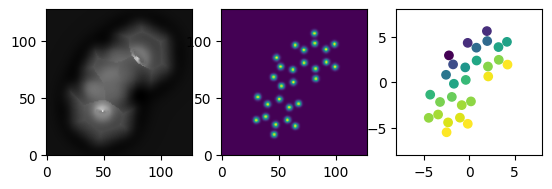

In [120]:
ax = plt.subplot(1, 3, 1)
ax.imshow(x[..., 5], cmap='gray', origin='lower')

ax = plt.subplot(1, 3, 2)
ax.imshow(y[..., -1].sum(0), origin='lower')

ax = plt.subplot(1, 3, 3)
ax.scatter(xyz[:, 0], xyz[:, 1], c=xyz[:, 2], cmap='viridis')
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_aspect('equal')
